# Plot AOU versus O2 Saturation 
Compute delta AOU and delta O2 saturation for different regiobs (global, tropics, extratropics)

In [32]:
%matplotlib inline

from itertools import product

import numpy as np

import pandas as pd
import xarray as xr
import intake

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

In [33]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

glade-cmip6-ESM Collection with 698724 entries:
	> 13 activity_id(s)

	> 24 institution_id(s)

	> 47 source_id(s)

	> 68 experiment_id(s)

	> 162 member_id(s)

	> 35 table_id(s)

	> 1027 variable_id(s)

	> 12 grid_label(s)

	> 59 dcpp_init_year(s)

	> 248 version(s)

	> 6813 time_range(s)

	> 698724 path(s)

Look at the options in the collection.

In [34]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,day,pr,gn,NaN,v20190702,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,hfls,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,prsn,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,va,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r2i1p1f1,Amon,tas,gn,NaN,v20190624,201501-205512,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...


In [35]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id','table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 68,
                   'values': ['ssp370', 'histSST-piNTCF', 'histSST',
                              'histSST-1950HC', 'hist-1950HC', 'hist-piNTCF',
                              'piClim-NTCF', 'ssp370SST-lowNTCF',
                              'ssp370-lowNTCF', 'ssp370SST', '1pctCO2-bgc',
                              'hist-bgc', 'esm-ssp585', 'amip-future4K',
                              'amip-m4K', 'a4SST', 'aqua-p4K', 'piSST',
                              'amip-4xCO2', 'a4SSTice', 'amip-p4K',
                              'aqua-control', 'aqua-4xCO2', 'abrupt-4xCO2',
                              'historical', 'piControl', 'amip', '1pctCO2',
                              'esm-hist', 'esm-piControl', 'ssp245', 'ssp585',
                              'ssp126', 'hist-GHG', 'hist-aer',
                              'dcppA-hindcast', 'dcppC-hindcast-noPinatubo',
                              'dcppC-hindcast-noElChichon', 'dcppA-assim',
                   

In [36]:
# Define which experiments you want

experiments = ['historical', 'ssp585']

def get_models(table_id, variable_id):
    # all models
    models = set(uni_dict['source_id']['values'])

    for experiment_id in experiments:
        query = dict(experiment_id=experiment_id, variable_id=variable_id, 
                     table_id=table_id, grid_label='gn')  
        cat = col.search(**query)
        models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

    # ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
    return models - {'CESM2-WACCM', 'CESM2'}
    

models = {}    

# look for models with O2 and O2sat
models['Omon.o2sat'] = get_models('Omon', 'o2sat')
have_sat = models['Omon.o2sat']

# find models with O2sat that also have O2
models['Omon.o2'] = get_models('Omon', 'o2').intersection(have_sat)

models_all = list(models['Omon.o2'])
models

{'Omon.o2sat': {'UKESM1-0-LL'}, 'Omon.o2': {'UKESM1-0-LL'}}

Only UKESM1-0-LL has O2, O2sat. Grab ones with conservative temperature (bigthetao), salinity (so), and pressure/depth to be able to calculate oxygen solubility?

In [37]:
df = pd.DataFrame()
for key, val in models.items():
    model_list = list(val)
    table_id = key.split('.')[0]
    variable_id = key.split('.')[1]
    
    cat = col.search(experiment_id=experiments, table_id=table_id, 
                     variable_id=variable_id, 
                     source_id=model_list, grid_label='gn')
    df = pd.concat((df, cat.df))

cat.df = df.copy()
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
195468,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,Omon,o2sat,gn,NaN,v20190708,200001-201412,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
195469,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
196832,CMIP,MOHC,UKESM1-0-LL,historical,r4i1p1f2,Omon,o2sat,gn,NaN,v20190708,195001-199912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
196833,CMIP,MOHC,UKESM1-0-LL,historical,r4i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
197664,CMIP,MOHC,UKESM1-0-LL,historical,r8i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
197665,CMIP,MOHC,UKESM1-0-LL,historical,r8i1p1f2,Omon,o2sat,gn,NaN,v20190708,200001-201412,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
198531,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,195001-199912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
198532,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
200396,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,o2sat,gn,NaN,v20190708,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
200397,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...


In [38]:
# specify a list of queries to eliminate
bad_member = [dict(member_id='r4i1p1f2')
               ]

# copy the dataframe 
df = cat.df.copy()

# eliminate data
for elim in bad_member:
    condition = np.ones(len(df), dtype=bool)
    for key, val in elim.items():
        condition = condition & (df[key] == val)
    df = df.loc[~condition]

cat.df = df
df

#dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
#                                cdf_kwargs={'chunks': {'time': 48}, 'decode_times': False})

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
195468,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,Omon,o2sat,gn,NaN,v20190708,200001-201412,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
195469,CMIP,MOHC,UKESM1-0-LL,historical,r3i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
197664,CMIP,MOHC,UKESM1-0-LL,historical,r8i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
197665,CMIP,MOHC,UKESM1-0-LL,historical,r8i1p1f2,Omon,o2sat,gn,NaN,v20190708,200001-201412,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
198531,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,195001-199912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
198532,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
200396,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,o2sat,gn,NaN,v20190708,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
200397,CMIP,MOHC,UKESM1-0-LL,historical,r2i1p1f2,Omon,o2sat,gn,NaN,v20190708,185001-189912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
637613,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r3i1p1f2,Omon,o2sat,gn,NaN,v20190813,210001-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
637769,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r8i1p1f2,Omon,o2sat,gn,NaN,v20190906,210001-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...


In [39]:
#dset_dict.keys()

In [40]:
#cat_fx = col.search(source_id=models_all, table_id='Ofx', grid_label='gn')
#cat_fx.df

# Choose just one matching member id and source id

In [41]:
df_Omon_o2_sat = df[(cat.df.table_id == 'Omon') & (cat.df.source_id == 'UKESM1-0-LL') & (cat.df.member_id == 'r1i1p1f2') & (cat.df.variable_id == 'o2sat')]
df_Omon_o2 = df[(cat.df.table_id == 'Omon') & (cat.df.source_id == 'UKESM1-0-LL') & (cat.df.member_id == 'r1i1p1f2') & (cat.df.variable_id == 'o2')]

df = pd.concat((df_Omon_o2, df_Omon_o2_sat))

cat.df = df.copy()
cat.df


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
198604,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2,gn,NaN,v20190627,195001-199912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
198605,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2,gn,NaN,v20190627,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
637871,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2,gn,NaN,v20190726,201501-204912,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
637872,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2,gn,NaN,v20190726,205001-209912,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
637873,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2,gn,NaN,v20190726,210001-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
198531,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,195001-199912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
198532,CMIP,MOHC,UKESM1-0-LL,historical,r1i1p1f2,Omon,o2sat,gn,NaN,v20190627,190001-194912,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
637855,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2sat,gn,NaN,v20190726,201501-204912,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
637856,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2sat,gn,NaN,v20190726,205001-209912,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...
637857,ScenarioMIP,MOHC,UKESM1-0-LL,ssp585,r1i1p1f2,Omon,o2sat,gn,NaN,v20190726,210001-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/MOHC...


In [42]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {'time': 48}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


In [43]:
dset_dict.keys()

dict_keys(['CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn', 'ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.Omon.gn'])

In [44]:
cat_fx = col.search(source_id='UKESM1-0-LL', table_id='Ofx', grid_label='gn')
cat_fx.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
201685,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,sftof,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201686,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,areacello,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201687,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,hfgeou,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201688,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,basin,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201689,CMIP,MOHC,UKESM1-0-LL,piControl,r1i1p1f2,Ofx,deptho,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...


In [45]:
# specify a list of queries to eliminate
corrupt_data = [dict(variable_id='areacello', source_id='IPSL-CM6A-LR',
                     experiment_id='historical', member_id='r2i1p1f1')
               ]

# copy the dataframe 
df = cat_fx.df.copy()

# eliminate data
for elim in corrupt_data:
    condition = np.ones(len(df), dtype=bool)
    for key, val in elim.items():
        condition = condition & (df[key] == val)
    df = df.loc[~condition]

df.drop_duplicates(subset=['source_id', 'variable_id'], inplace=True)
df['member_id'] = np.nan
cat_fx.df = df
df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
201685,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,sftof,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201686,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,areacello,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201687,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,hfgeou,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201688,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,basin,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201689,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,deptho,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...


In [46]:
fx_dsets = cat_fx.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                  cdf_kwargs={'chunks': {}, 'decode_times': False})
cat_fx.df


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
201685,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,sftof,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201686,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,areacello,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201687,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,hfgeou,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201688,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,basin,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...
201689,CMIP,MOHC,UKESM1-0-LL,piControl,NaN,Ofx,deptho,gn,NaN,v20190705,NaN,/glade/collections/cmip/CMIP6/CMIP/MOHC/UKESM1...


In [47]:
fx_dsets.keys()

dict_keys(['CMIP.MOHC.UKESM1-0-LL.piControl.Ofx.gn'])

In [48]:
for key, ds in fx_dsets.items():
    print(key)
    print(ds.data_vars)
    print()

CMIP.MOHC.UKESM1-0-LL.piControl.Ofx.gn
Data variables:
    latitude            (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(330, 360, 4), meta=np.ndarray>
    type                |S3 ...
    sftof               (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    areacello           (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    hfgeou              (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>
    basin               (j, i) float64 dask.array<chunksize=(330, 360), meta=np.ndarray>
    deptho              (j, i) float32 dask.array<chunksize=(330, 360), meta=np.ndarray>



# Attempt to plot some parameters
Use the keys created for the catalog in order to pull out historical or RCP 8.5 scenarios.

In [51]:
historical = dset_dict['CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn']
ssp585 = dset_dict['ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.Omon.gn']

In [57]:
# Create initial conditions
time_0 = historical.sel(time = '1970-01-16')
time_1970_to_1999 = historical.sel(time = slice('1970-01-16', '1999-12-16'))
all_time = xr.concat([time_1970_to_1999,ssp585], dim='time')

In [58]:
all_time

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 330, lev: 75, member_id: 1, time: 1392, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
  * member_id           (member_id) <U8 'r1i1p1f2'
  * lev                 (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time                (time) object 1970-01-16 00:00:00 ... 2100-12-16 00:00:00
Dimensions without coordinates: bnds, vertices
Data variables:
    vertices_latitude   (time, j, i, vertices) float32 -84.16006 ... 50.10834
    longitude           (time, j, i) float32 73.5 74.5 ... 72.96297 72.98915
    vertices_longitude  (time, j, i, vertices) float32 73.0 74.0 ... 73.0 73.0
    lev_bnds            (time, lev, bnds) float64 0.0 1.024 ... 6.004e+03
    latitude            (time, j, i) float32 -84.108955 -84.108955 ... 50.01094
    time_bnds           (time, bnds) object das

In [ ]:
# Calculate AOU for each point in time from time_0 to 2100:
aou_1970_to_1999 = time_0['o2sat']-time_0['o2']
aou_1970_to_1999

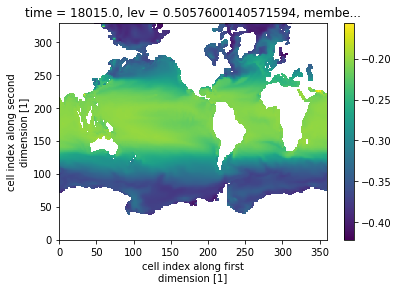

In [74]:
hist_aou = historical['o2sat']-historical['o2']
hist_aou.isel(member_id = 0, time = 0, lev = 0).plot()

In [81]:
hist_aou.values

KeyboardInterrupt: 

In [23]:
ssp585.time[0]

<xarray.DataArray 'time' ()>
array(cftime.Datetime360Day(2015, 1, 16, 0, 0, 0, 0, 5, 16), dtype=object)
Coordinates:
    time     object 2015-01-16 00:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time